In [1]:
track = 'https://envirocar.org/api/stable/tracks/642d15945244bc763cc65e0f'
streets = 'https://overpass-api.de/api/interpreter?data=[out%3Ajson][timeout%3A25]%3B%0A(%0A%20%20way["highway"~"^(motorway|trunk|primary|residential|tertiary|motorway_link|unclassified|service|secondary|secondary_link)%24"](48.7%2C9.01%2C48.735%2C9.13)%3B%0A)%3B%0Aout%20geom%3B'

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [4]:
import geopandas as gp
from shapely.geometry import shape
import requests
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
import json
import time

In [5]:
response = requests.get(streets)
mystreets = response.json()['elements']
for d in mystreets:
    coords = []
    for p in d['geometry']:
        coords.append((p['lon'],p['lat']))
    data = {"type": "LineString", "coordinates": coords}
    d['geometry'] = shape(data)
gdf = gp.GeoDataFrame(mystreets).set_geometry('geometry')
#gdf.head()

In [6]:
mytrack = gp.read_file(track)
#mytrack

In [7]:
tmp_list = []
for x in range(0,mytrack.shape[0],4):
    tmp_list.append({
      'id': mytrack.loc[x,'id'],
      'time': mytrack.loc[x,'time'],
      'phenomenons': mytrack.loc[x,'phenomenons'],
      'geometry': mytrack.loc[x,'geometry']
     })
subTracks = gp.GeoDataFrame(tmp_list)
#subTracks

In [8]:
subTracks

,id,time,phenomenons,geometry
0,642d15945244bc763cc65e11,2023-04-05 06:30:31+00:00,{'Maximum Acceleration': {'value': 7.215007215...,POINT (9.01501 48.70868)
1,642d15a85244bc763cc65e1b,2023-04-05 06:30:47+00:00,"{'GPS Accuracy': {'value': 6.000000178813934, ...",POINT (9.01563 48.70837)
2,642d15a85244bc763cc65e1f,2023-04-05 06:30:56+00:00,"{'Rpm': {'value': 1473.794745773077, 'unit': '...",POINT (9.01683 48.70809)
3,642d15bf5244bc763cc65e26,2023-04-05 06:31:04+00:00,"{'GPS PDOP': {'value': 2.0311043560504913, 'un...",POINT (9.01824 48.70775)
4,642d15bf5244bc763cc65e2b,2023-04-05 06:31:12+00:00,"{'Rpm': {'value': 1361.6756262481213, 'unit': ...",POINT (9.01961 48.70744)
...,...,...,...,...
133,642d19f65244bc763cc660fd,2023-04-05 06:49:09+00:00,"{'GPS PDOP': {'value': 1.7, 'unit': 'precision...",POINT (9.11757 48.72712)
134,642d19f65244bc763cc66101,2023-04-05 06:49:17+00:00,"{'Rpm': {'value': 1991.0551168173552, 'unit': ...",POINT (9.11754 48.72668)
135,642d1a0c5244bc763cc66108,2023-04-05 06:49:25+00:00,"{'GPS PDOP': {'value': 1.8687755107879638, 'un...",POINT (9.11840 48.72653)
136,642d1a0c5244bc763cc6610d,2023-04-05 06:49:34+00:00,"{'GPS PDOP': {'value': 1.8841893255710602, 'un...",POINT (9.11881 48.72639)


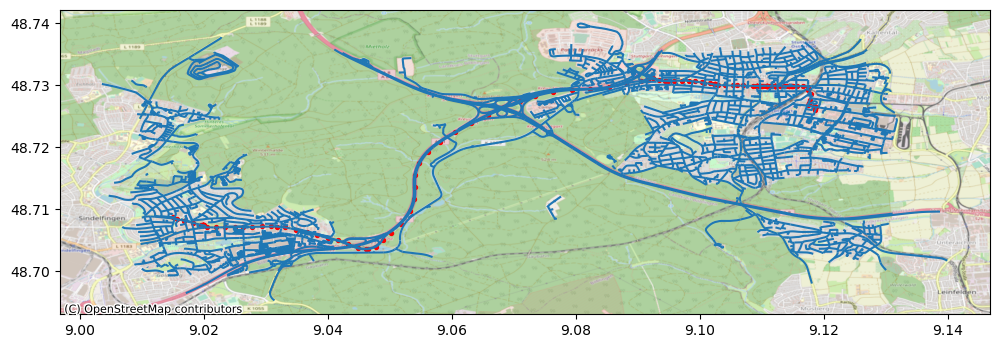

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = subTracks.plot(ax=gdf.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

In [10]:
puffer = subTracks.buffer(0.001)

In [11]:
puffergdf = gp.GeoDataFrame(geometry=puffer)

In [12]:
puffergdf.insert(0, "Id", range(1,1+len(puffergdf)))

In [13]:
tempStreets2 = gp.GeoDataFrame()
for puff in puffergdf.iterrows():
    tempStreets = []
    tempStreets = gp.overlay(gdf, gp.GeoDataFrame(geometry=[puff[1]['geometry']]), how='intersection')
    tempStreets['pufferId'] = puff[1]['Id']
    tempStreets2 = pd.concat([tempStreets2,tempStreets])

In [14]:
import shapely

In [15]:
snappedPoints = []
i=0
for index, row in tempStreets2.iterrows():
    activePoint = subTracks.loc[row['pufferId']-1]
    snappedPoints.append({
        'id': i,
        'pufferId': row['pufferId'],
        'pointId': activePoint['id'],
        'geometry': row['geometry'].interpolate(row['geometry'].project(activePoint.geometry))
     })
    i = i+1
snappedPointsGdf = gp.GeoDataFrame(snappedPoints)

In [16]:
#snappedPointsGdf.plot()

In [17]:
#snappedPointsGdf

In [18]:
koordinaten = {}
for index, row in snappedPointsGdf.iterrows():
    koordinaten[row['id']] = (row['geometry'].x, row['geometry'].y)
#koordinaten

In [19]:
#puffergdf

In [20]:
init_graph1 = {}
lastIndex = -1
for index, puffrow in puffergdf.iterrows():
    if lastIndex != -1: #nicht erste iteration
        tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffrow['Id']]
        for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
            init_graph1[firstCol['id']] = list(tempPoints['id'])
    lastIndex = puffrow['Id']
#init_graph1

In [21]:
#init_graph1

In [22]:
def getDistances(sourcePs, destPs, metrics = "duration"):
    # bei "duration" antwort in Sekunden
    # dei "distance" antwort in Metern
    url = "https://api.openrouteservice.org/v2/matrix/driving-car"
    N = len(sourcePs)
    M = len(destPs)
    locations = sourcePs + destPs
    body = {"locations":locations, "destinations":list(range(N,N+M)), "sources":list(range(0,N)), "metrics":[metrics]}
    # spalten nach destinations, zeile nach sources
    headers = {'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf6248313acae367214955a3dcb710c5e4e0b8',
    'Content-Type': 'application/json; charset=utf-8'}
    call = requests.post(url, json=body, headers=headers)
    #print(json.loads(call.text))
    edgeValues = json.loads(call.text)[metrics+"s"]
    return edgeValues

In [23]:
def createForks(sourcePIDs, destPIDs, distMatrix):
    retDict = {}
    for sPID in sourcePIDs:
        retDict[sPID] = {}
    for j in range(0, len(sourcePIDs)):
        sourcePID = sourcePIDs[j]
        for i in range(0, len(destPIDs)):
            #print(i)
            retDict[sourcePID][destPIDs[i]] = distMatrix[j][i]
    return retDict

In [24]:
def createDistGraph(pDict, forkDict, metrics = "duration"):
    outputGraph = {}
    for sourcePID, destPIDList in forkDict.items():
        tempDestPDict = {}
        for destPID in destPIDList:
            tempDestPDict[destPID] = pDict[destPID]
            pDict[sourcePID]
            outputGraph.update(createForks([sourcePID],list(tempDestPDict.keys()),getDistances([pDict[sourcePID]],list(tempDestPDict.values()), metrics = metrics)))
    return outputGraph

In [25]:
def createProbGraph(pDict, forkDict, metrics = "duration"):
    #TODO: Kantenwerte als Wahrscheinlichkeioten...
    outputGraph = {}
    for sourcePID, destPIDList in forkDict.items():
        tempDestPDict = {}
        for destPID in destPIDList:
            tempDestPDict[destPID] = pDict[destPID]
            pDict[sourcePID]
            distances = getDistances([pDict[sourcePID]],list(tempDestPDict.values()), metrics = metrics)
            total = sum(distances[0])                         
            ws = []
            for value in distances[0]:
                ws.append(value/total)
            outputGraph.update(createForks([sourcePID],list(tempDestPDict.keys()),[ws]))
            time.sleep(5)
    return outputGraph

In [26]:
createProbGraph(koordinaten, init_graph1)

KeyError: 'durations'

In [ ]:
d_graph = {}
d_graph[-1] = {}
for index, node in snappedPointsGdf.iterrows():
    d_graph[node['id']] = {}
lastIndex = -1
for index, puffrow in puffergdf.iterrows():
    tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffrow['Id']]
    summe = 0
    for index, tp1 in tempPoints.iterrows():
        actSnappedPoint = (tp1['geometry'].x, tp1['geometry'].y)
        actBasePoint = (subTracks['geometry'].iloc[puffrow['Id']-1].x, subTracks['geometry'].iloc[puffrow['Id']-1].y)
        abstand = distance.euclidean(actSnappedPoint, actBasePoint)
        summe = summe + abstand
    if lastIndex == -1:
        for index, tp in tempPoints.iterrows():
            actSnappedPoint = (tp['geometry'].x, tp['geometry'].y)
            actBasePoint = (subTracks['geometry'].iloc[puffrow['Id']-1].x, subTracks['geometry'].iloc[puffrow['Id']-1].y)
            abstand = distance.euclidean(actSnappedPoint, actBasePoint)
            d_graph[-1][tp['id']] = 1-(abstand/summe)
    else:
        for i, secondCol in tempPoints.iterrows():
            for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
                firstColPoint = (firstCol['geometry'].x, firstCol['geometry'].y)
                secColPoint = (secondCol['geometry'].x, secondCol['geometry'].y)
                abstand = distance.euclidean(firstColPoint, secColPoint)
                d_graph[firstCol['id']][secondCol['id']] = (1-(abstand/summe)) * 100
    lastIndex = puffrow['Id']
for index, pts in snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffergdf['Id'].max()].iterrows():
    d_graph[pts['id']][-2] = 0

In [ ]:
#d_graph

In [ ]:
els = list(d_graph.items())
els[-1]

In [ ]:
class Graph():
 
    def __init__(self, vertices):
        self.V = vertices
        self.graph = [[0 for column in range(vertices)]
                      for row in range(vertices)]
 
    def printSolution(self, dist):
        print("Vertex \t Distance from Source")
        for node in range(self.V):
            print(node, "\t\t", dist[node])
 
    # A utility function to find the vertex with
    # minimum distance value, from the set of vertices
    # not yet included in shortest path tree
    def minDistance(self, dist, sptSet):
 
        # Initialize minimum distance for next node
        min = 1e7
 
        # Search not nearest vertex not in the
        # shortest path tree
        for v in range(self.V):
            if dist[v] < min and sptSet[v] == False:
                min = dist[v]
                min_index = v
 
        return min_index
 
    # Function that implements Dijkstra's single source
    # shortest path algorithm for a graph represented
    # using adjacency matrix representation
    def dijkstra(self, src):
 
        dist = [1e7] * self.V
        dist[src] = 0
        sptSet = [False] * self.V
        sptSet2 = [False] * self.V
        i = 1
 
        for cout in range(self.V):
 
            # Pick the minimum distance vertex from
            # the set of vertices not yet processed.
            # u is always equal to src in first iteration
            u = self.minDistance(dist, sptSet)
 
            # Put the minimum distance vertex in the
            # shortest path tree
            sptSet[u] = True
            sptSet[u] = i
 
            # Update dist value of the adjacent vertices
            # of the picked vertex only if the current
            # distance is greater than new distance and
            # the vertex in not in the shortest path tree
            for v in range(self.V):
                if (self.graph[u][v] > 0 and
                   sptSet[v] == False and
                   dist[v] > dist[u] + self.graph[u][v]):
                    dist[v] = dist[u] + self.graph[u][v]
            i = i+1
            print(sptSet)
        self.printSolution(dist)

In [ ]:
 # Driver program
g = Graph(9)
g.graph = [[0, 0, 0, 0, 0, 0, 0, 8, 0],
           [4, 0, 8, 0, 0, 0, 0, 11, 0],
           [0, 0, 0, 7, 0, 4, 0, 0, 2],
           [0, 0, 7, 0, 9, 14, 0, 0, 0],
           [0, 0, 0, 9, 0, 10, 0, 0, 0],
           [0, 0, 4, 14, 10, 0, 2, 0, 0],
           [0, 0, 0, 0, 0, 2, 0, 1, 6],
           [8, 11, 0, 0, 0, 0, 1, 0, 7],
           [0, 0, 2, 0, 0, 0, 6, 7, 0]
           ]
 
g.dijkstra(0)

##TODO prüfen ob ergebnis richtig
##TODO ergänzen von abgelaufenen weg (folge von PunktIds) ans ergebnis (nicht nur die enddistanz)